### Edgar Moises Hernandez-Gonzalez
#### 28/01/20-27/02/20
#### Clasificacion de imagenes motoras en EEG con CNN-3D, CNN-2D + LSTM, CNN-2D + GRU y ConvLSTM2D
##### Caracteristicas = Espectrogramas STFFT (4D)
##### 5 ejecuciones independientes

#### CNN-3D
##### Sujeto 1
##### Accuracy = 63.19%
##### Kappa = 0.5093

#### CNN-3D BN
##### Sujeto 1
##### Accuracy = 53.47%
##### Kappa = 0.3796

#### CNN-2D + LSTM
##### Sujeto 1
##### Accuracy = 48.61%
##### Kappa = 0.3148

#### CNN-2D + LSTM BN
##### Sujeto 1
##### Accuracy = 40.97%
##### Kappa = 0.2130

#### CNN-2D + GRU
##### Sujeto 1
##### Accuracy = 51.04%
##### Kappa = 0.3472

#### CNN-2D + GRU BN
##### Sujeto 1
##### Accuracy = 42.71%
##### Kappa = 0.2361

#### ConvLSTM2D
##### Sujeto 1
##### Accuracy = 48.96%
##### Kappa = 0.3194

#### ConvLSTM2D BN
##### Sujeto 1
##### Accuracy = 48.26%
##### Kappa = 0.3102

In [0]:
from google.colab import drive

In [0]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from scipy.signal import spectrogram
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv3D, MaxPool3D, Flatten, Dense, Dropout,
                                     TimeDistributed, Conv2D, MaxPool2D, LSTM,
                                     GRU, ConvLSTM2D, BatchNormalization,
                                     Activation)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

In [0]:
# para que este script funcione debe de decir 'channels_last', si dice 'channels_first' no sirve
K.image_data_format()

'channels_last'

In [0]:
x_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A01T.csv", header=None)
x_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A01E.csv", header=None)
y_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasA01T.csv", header=None)
y_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasA01E.csv", header=None)

In [0]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(288, 22000)
(288, 22000)
(288, 1)
(288, 1)


In [0]:
n_samples_train = len(y_train)
n_samples_test = len(y_test) #en caso de no tener el y_test se puede utilizar el x_test

print("n_samples_train:", n_samples_train)
print("n_samples_test :", n_samples_test)

n_samples_train: 288
n_samples_test : 288


In [0]:
n_classes = len(np.unique(y_test)) #esto se podria calcular asi n_clases = len(np.unique(y)), la y puede ser train o test

print("n_classes:", n_classes)

n_classes: 4


In [0]:
#codificar etiquetas con valores de 0 a nClases-1
le = LabelEncoder().fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
#22 canales
def espectrogramas(data):
  fs = 250
  datos = np.zeros((288,22,24,4))
  for i in range(data.shape[0]): #288 muestras
    for j in range(22): #22 canales
      sig = data.iloc[i, j*1000:(j+1)*1000]
      f, t, Sxx = spectrogram(sig, fs) #espectrograma de STFFT
      datos[i,j] = Sxx[8:32, :]
  return datos

In [0]:
#llamar a espectrogramas(data)
x_train = espectrogramas(x_train)
x_test = espectrogramas(x_test)

In [0]:
print(x_train.shape)
print(x_test.shape)

(288, 22, 24, 4)
(288, 22, 24, 4)


In [0]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))

127.36705810165053
103.14882408038861
3.3899630126531786e-07
5.741129212423684e-07


In [0]:
#convertir a float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#escalar los valores en un rango de 0 a 1 (normalizar)
x_train /= 128.0
x_test /= 128.0

In [0]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))

0.99505514
0.8058502
2.6484086e-09
4.485257e-09


In [0]:
#convertir de 4D a 5D
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], x_train.shape[3], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], x_test.shape[3], 1))

print(x_train.shape)
print(x_test.shape)

(288, 22, 24, 4, 1)
(288, 22, 24, 4, 1)


In [0]:
'''def CNN_3D():
    model = Sequential()
    model.add(Conv3D(128, (1,3,3), activation='relu', padding='same',
                     input_shape=x_train.shape[1:]))
    model.add(MaxPool3D((1,2,2)))
    model.add(Conv3D(128, (1,3,3), activation='relu', padding='same'))
    model.add(MaxPool3D((1,2,2)))
    model.add(Conv3D(128, (1,3,3), activation='relu', padding='same'))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(n_classes, activation='softmax'))
    
    optimizer = Adam(lr=1e-5)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model'''

"def CNN_3D():\n    model = Sequential()\n    model.add(Conv3D(128, (1,3,3), activation='relu', padding='same',\n                     input_shape=x_train.shape[1:]))\n    model.add(MaxPool3D((1,2,2)))\n    model.add(Conv3D(128, (1,3,3), activation='relu', padding='same'))\n    model.add(MaxPool3D((1,2,2)))\n    model.add(Conv3D(128, (1,3,3), activation='relu', padding='same'))\n    model.add(Flatten())\n    model.add(Dense(64, activation='relu'))\n    model.add(Dropout(0.2))\n    model.add(Dense(n_classes, activation='softmax'))\n    \n    optimizer = Adam(lr=1e-5)\n    model.compile(optimizer=optimizer,\n                  loss='sparse_categorical_crossentropy',\n                  metrics=['accuracy'])\n    return model"

In [0]:
'''def CNN_3D_BN():
    model = Sequential()
    model.add(Conv3D(128, (1,3,3), padding='same',
                     input_shape=x_train.shape[1:]))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPool3D((1,2,2)))
    model.add(Conv3D(128, (1,3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPool3D((1,2,2)))
    model.add(Conv3D(128, (1,3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(64))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(n_classes, activation='softmax'))
    
    optimizer = Adam(lr=1e-5)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model'''

In [0]:
'''def CNN_2D_LSTM_TD():
  model = Sequential()
  model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu', padding='same'),
                            input_shape=x_train.shape[1:]))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu', padding='same')))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(32))
  model.add(Dropout(0.5))
  model.add(Dense(n_classes, activation='softmax'))
    
  optimizer = Adam(lr=1e-5)
  model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model'''

In [0]:
'''def CNN_2D_LSTM_TD_BN():
  model = Sequential()
  model.add(TimeDistributed(Conv2D(32, (3,3), padding='same'),
                            input_shape=x_train.shape[1:]))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(Activation('relu')))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Conv2D(32, (3,3), padding='same')))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(Activation('relu')))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(32))
  model.add(BatchNormalization()) #la activacion antes de BN porque es tanh
  model.add(Dense(n_classes, activation='softmax'))
    
  optimizer = Adam(lr=1e-5)
  model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model'''

In [0]:
'''def CNN_2D_GRU_TD():
  model = Sequential()
  model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu', padding='same'),
                            input_shape=x_train.shape[1:]))
  model.add(TimeDistributed(Flatten()))
  model.add(GRU(32))
  model.add(Dense(n_classes, activation='softmax'))
    
  optimizer = Adam(lr=1e-5)
  model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model'''

In [0]:
'''def CNN_2D_GRU_TD_BN():
  model = Sequential()
  model.add(TimeDistributed(Conv2D(32, (3,3), padding='same'),
                            input_shape=x_train.shape[1:]))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(Activation('relu')))
  model.add(TimeDistributed(Flatten()))
  model.add(GRU(32))
  model.add(BatchNormalization()) #la activacion va antes de BN porque es tanh
  model.add(Dense(n_classes, activation='softmax'))
    
  optimizer = Adam(lr=1e-4)
  model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model'''

In [0]:
'''def Conv_LSTM_2D():
  model = Sequential()
  model.add(ConvLSTM2D(64, (3,3), activation='relu', padding='same',
                       input_shape=x_train.shape[1:]))
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(n_classes, activation='softmax'))
    
  optimizer = Adam(lr=1e-5)
  model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model'''

In [0]:
def Conv_LSTM_2D_BN():
    model = Sequential()
    model.add(ConvLSTM2D(64, (3,3), padding='same',
                         input_shape=x_train.shape[1:]))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(n_classes, activation='softmax'))
    
    optimizer = Adam(lr=1e-5)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

Iteration: 1
288/288 - 0s - loss: 1.9512 - acc: 0.4688
kappa:  0.29166666666666663
f1: 0.4680662338230576
confusion matrix:
 [[26 30 12  4]
 [19 43  8  2]
 [ 9 17 33 13]
 [ 9  7 23 33]]


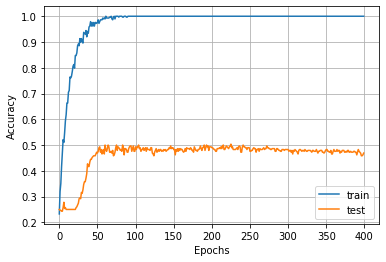

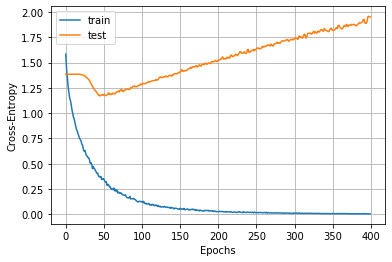

Iteration: 2
288/288 - 0s - loss: 1.8868 - acc: 0.4722
kappa:  0.2962962962962963
f1: 0.4727384760764606
confusion matrix:
 [[27 23 17  5]
 [18 36 13  5]
 [ 9  8 37 18]
 [ 7  3 26 36]]


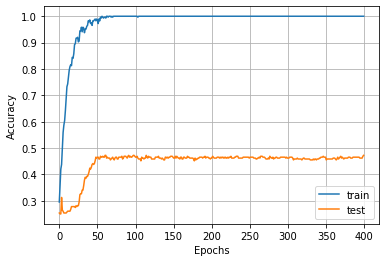

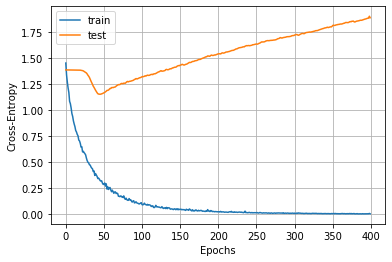

Iteration: 3
288/288 - 0s - loss: 1.9505 - acc: 0.4583
kappa:  0.2777777777777778
f1: 0.4594738152474801
confusion matrix:
 [[28 28 10  6]
 [23 38  8  3]
 [ 9 16 31 16]
 [14  5 18 35]]


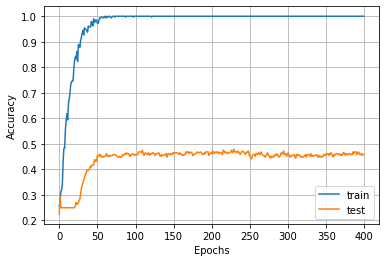

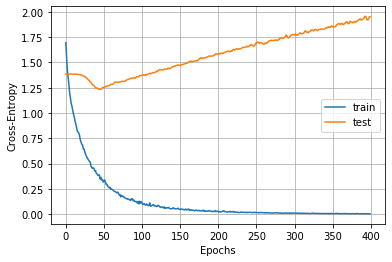

Iteration: 4
288/288 - 0s - loss: 1.8961 - acc: 0.4826
kappa:  0.31018518518518523
f1: 0.482785060418041
confusion matrix:
 [[26 25 15  6]
 [19 37 11  5]
 [12  9 38 13]
 [ 8  4 22 38]]


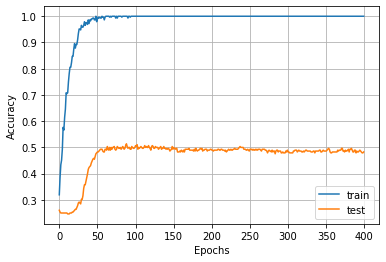

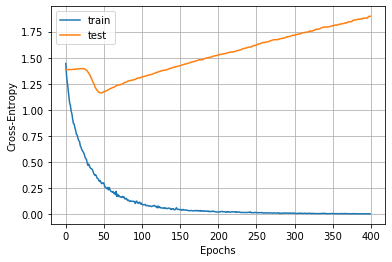

Iteration: 5
288/288 - 0s - loss: 2.0370 - acc: 0.4306
kappa:  0.2407407407407407
f1: 0.4284512163435974
confusion matrix:
 [[22 30 14  6]
 [16 38 14  4]
 [ 9 14 29 20]
 [ 9  6 22 35]]


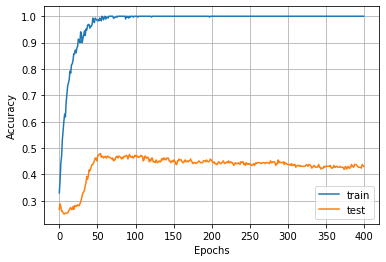

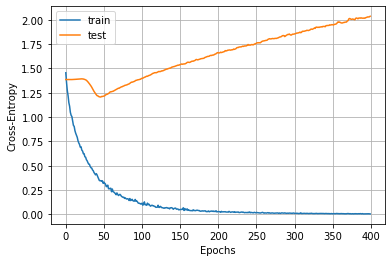


Resultados:
loss: [1.951208922598097, 1.8868147532145183, 1.9505389398998685, 1.89606331454383, 2.0369531446033053]
accuracy: [0.46875, 0.4722222, 0.45833334, 0.4826389, 0.43055555]
kappa: [0.29166666666666663, 0.2962962962962963, 0.2777777777777778, 0.31018518518518523, 0.2407407407407407]
f1: [0.4680662338230576, 0.4727384760764606, 0.4594738152474801, 0.482785060418041, 0.4284512163435974]


In [0]:
array_loss = []
array_acc = []
array_kappa = []
for i in range(5):
  print("Iteration:", i+1)
    
  #model = CNN_3D()
  #model = CNN_3D_BN()
  #model = CNN_2D_LSTM_TD()
  #model = CNN_2D_LSTM_TD_BN()
  #model = CNN_2D_GRU_TD()
  #model = CNN_2D_GRU_TD_BN()
  #model = Conv_LSTM_2D()
  model = Conv_LSTM_2D_BN()

  history = model.fit(x_train, y_train, epochs=400, batch_size=18,
                      validation_data=(x_test, y_test), verbose=0)
    
  test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
  array_loss.append(test_loss)
  array_acc.append(test_acc)
    
  probabilidades = model.predict(x_test)
  y_pred = np.argmax(probabilidades, 1) #1=fila
    
  kappa = cohen_kappa_score(y_test, y_pred)
  array_kappa.append(kappa)
  print("kappa: ", kappa)
    
  matriz_confusion = confusion_matrix(y_test, y_pred)
  print("confusion matrix:\n", matriz_confusion)
    
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'test'])
  plt.show()
    
print() 
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("kappa:", array_kappa)

In [0]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_10 (ConvLSTM2D) (None, 24, 4, 64)         150016    
_________________________________________________________________
batch_normalization_20 (Batc (None, 24, 4, 64)         256       
_________________________________________________________________
activation_20 (Activation)   (None, 24, 4, 64)         0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 6144)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 256)               1573120   
_________________________________________________________________
batch_normalization_21 (Batc (None, 256)               1024      
_________________________________________________________________
activation_21 (Activation)   (None, 256)             

In [0]:
print("Mean Accuracy: %.4f" % np.mean(array_acc))
print("std: (+/- %.4f)" % np.std(array_acc))
print("Mean Kappa: %.4f" % np.mean(array_kappa))
print("std: (+/- %.4f)" % np.std(array_kappa))
print("Max Accuracy: %.4f" % np.max(array_acc))
print("Max Kappa: %.4f" % np.max(array_kappa))

Mean Accuracy: 0.4625
std: (+/- 0.0178)
Mean Kappa: 0.2833
std: (+/- 0.0237)
Mean F1: 0.4623
Max Accuracy: 0.4826
Max Kappa: 0.3102
Max F1: 0.4828
